# Dikemodel continued - subspace partitioning

Scenario discovery.... (nog uitleg toevoegen)

## 1. Apply scenario discovery

**1.** Import model from Open Exploration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation2 import get_model_for_problem_formulation, sum_over, sum_over_time

**2.** Import results from Open Exploration

bla bla importeren en levers weghalen



In [3]:
from ema_workbench import load_results

# Laad de resultaten
results = load_results('dike_open_exploration_results.tar.gz')
#results = load_results("dike_open_exploration_with_allcosts.tar.gz")
experiments, outcomes = results


lever_columns = [
    '0_RfR 0', '0_RfR 1', '0_RfR 2',
    '1_RfR 0', '1_RfR 1', '1_RfR 2',
    '2_RfR 0', '2_RfR 1', '2_RfR 2',
    '3_RfR 0', '3_RfR 1', '3_RfR 2',
    '4_RfR 0', '4_RfR 1', '4_RfR 2',
    'EWS_DaysToThreat',
    'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
    'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
    'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
    'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
    'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2'
]

cleaned_experiments = experiments.drop(columns=lever_columns)

In [4]:
cleaned_experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2,scenario,policy,model
0,67,198.900645,1.0,0.372834,238.339493,1.5,0.786464,80.188588,10.0,0.504933,...,0.899967,246.844838,10.0,0.047758,1.5,1.5,2.5,10,0,dikesnet
1,101,57.326132,1.0,0.568367,175.061774,1.0,0.844786,149.950574,10.0,0.928523,...,0.318020,284.307720,10.0,0.609510,2.5,2.5,3.5,11,0,dikesnet
2,121,67.063516,10.0,0.938312,270.629577,1.5,0.556535,49.813986,10.0,0.335718,...,0.052276,170.513109,1.5,0.777199,3.5,3.5,2.5,12,0,dikesnet
3,56,97.260067,10.0,0.455471,113.687533,10.0,0.672152,111.818775,1.0,0.862253,...,0.191436,70.653195,10.0,0.902056,4.5,2.5,3.5,13,0,dikesnet
4,9,340.425386,10.0,0.690315,140.489083,1.5,0.278687,302.205285,1.5,0.153556,...,0.250454,149.698714,1.5,0.478670,2.5,3.5,1.5,14,0,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,86,249.214689,10.0,0.259818,39.664694,10.0,0.080348,235.314612,1.5,0.031335,...,0.923761,313.523764,1.0,0.869961,3.5,1.5,4.5,15,9,dikesnet
96,21,275.833579,1.5,0.834323,204.939710,1.0,0.370399,187.178754,1.0,0.495657,...,0.703805,192.289977,1.0,0.192299,1.5,3.5,1.5,16,9,dikesnet
97,113,136.058187,1.5,0.085186,308.809039,1.0,0.495337,337.551514,1.0,0.637073,...,0.643368,103.139684,1.5,0.317740,1.5,2.5,4.5,17,9,dikesnet
98,34,184.636436,1.5,0.189611,322.896456,10.0,0.144169,193.492487,10.0,0.756643,...,0.416763,318.716682,1.0,0.299387,4.5,4.5,2.5,18,9,dikesnet


**3.** Apply scenario discovery

neem de data die onder de.... aan kosten is, doe daar een prim analyse op. je krijgt leuk plaatje

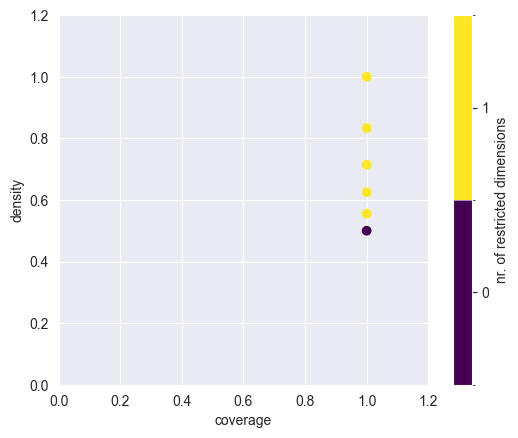

In [5]:
from ema_workbench.analysis import prim
import numpy as np

# See outcome
data_rfrtotalcost = outcomes['RfR Total Costs']

# Define wanted outcome
y_rfrtotalcost = ((data_rfrtotalcost >= 1000000000) & (data_rfrtotalcost <= 1400000000)).astype(bool)

# plt.hist(data_rfrtotalcost)

# PRIM-analyse
prim_alg_rfrtotalcost = prim.Prim(cleaned_experiments, y_rfrtotalcost, threshold=0.8)
box_rfrtotalcost = prim_alg_rfrtotalcost.find_box()
box_rfrtotalcost.show_tradeoff()
plt.show()


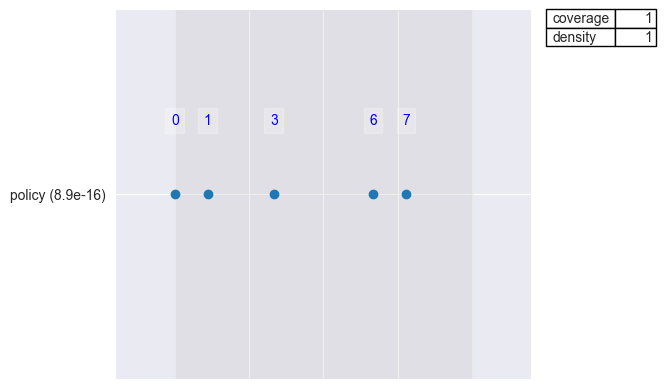

In [6]:
# box_rfrtotalcost.inspect()
box_rfrtotalcost.inspect(style='graph')
plt.show()

In [7]:
# x = cleaned_experiments.reset_index(drop=True)
# # Boolean array van experimenten in de box
# in_box_rfrtotalcost = box_rfrtotalcost.yi  # Deze is altijd even lang als x na reset_index
#
# # Selecteer de experimenten die in de box vallen
# experiments_in_box_rfrtotalcost = x.loc[in_box_rfrtotalcost]
#
# # Unieke policies selecteren
# robust_policies_rfrtotalcost = experiments_in_box_rfrtotalcost['policy'].unique()
#
# # Robuuste policies opzoeken in originele experimenten
# robust_policies_df_rfrtotalcost = experiments[experiments['policy'].isin(robust_policies_rfrtotalcost)].drop_duplicates(subset='policy')
#
# # Toon resultaat
# print("Robust Policies for RfR Total Costs:")
# display(robust_policies_df_rfrtotalcost)


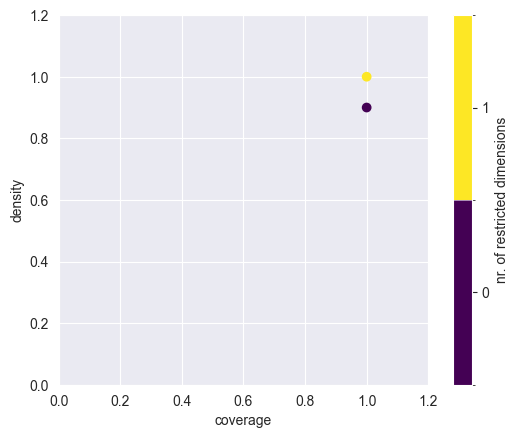

In [8]:
# See outcome
data_dike_inv = outcomes['Dike Investment Costs']

# Define wanted outcome
y_dike_inv = (data_dike_inv <= 600000000).astype(bool)

# plt.hist(data_dike_inv)

# PRIM-analyse
prim_alg_dike_inv = prim.Prim(cleaned_experiments, y_dike_inv, threshold=0.8)
box_dike_inv = prim_alg_dike_inv.find_box()
box_dike_inv.show_tradeoff()
plt.show()

coverage     1.0
density      1.0
id           1.0
k           90.0
mass         0.9
mean         1.0
n           90.0
res_dim      1.0
Name: 1, dtype: float64

                              box 1                                         \
                                min                          max  qp value   
policy  {0, 1, 2, 3, 4, 6, 7, 8, 9}  {0, 1, 2, 3, 4, 6, 7, 8, 9}  0.000076   

                 
       qp value  
policy      NaN  



/Users/evalievanoijen/PycharmProjects/group25_mbdm/venv/lib/python3.13/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{0, 1, 2, 3, 4, 6, 7, 8, 9}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
/Users/evalievanoijen/PycharmProjects/group25_mbdm/venv/lib/python3.13/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{0, 1, 2, 3, 4, 6, 7, 8, 9}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]


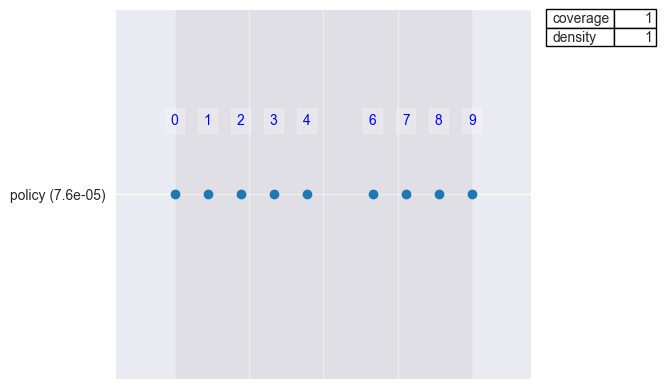

In [9]:
box_dike_inv.inspect()
box_dike_inv.inspect(style='graph')
plt.show()

In [10]:
# x = cleaned_experiments.reset_index(drop=True)
# # Boolean array van experimenten in de box
# in_box_dike_inv = box_dike_inv.yi  # Deze is altijd even lang als x na reset_index
#
# # Selecteer de experimenten die in de box vallen
# experiments_in_box_dike_inv = x.loc[in_box_dike_inv]
#
# # Unieke policies selecteren
# robust_policies_dike_inv = experiments_in_box_dike_inv['policy'].unique()
#
# # Robuuste policies opzoeken in originele experimenten
# robust_policies_df_dike_inv = experiments[experiments['policy'].isin(robust_policies_dike_inv)].drop_duplicates(subset='policy')
#
# # Toon resultaat
# print("Robust Policies for Dike Investment Costs:")
# display(robust_policies_df_dike_inv)

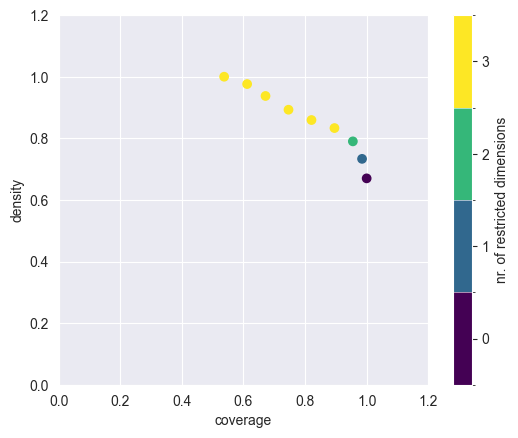

In [11]:
# See outcome
data_expanndamage = outcomes['Expected Annual Damage']

# See wanted outcome
y_expanndamage = (data_expanndamage <= 5000000).astype(bool)

# plt.hist(data_expanndamage)

# PRIM-analyse
prim_alg_expanndamage = prim.Prim(cleaned_experiments, y_expanndamage, threshold=0.8)
box_expanndamage = prim_alg_expanndamage.find_box()
box_expanndamage.show_tradeoff()
plt.show()

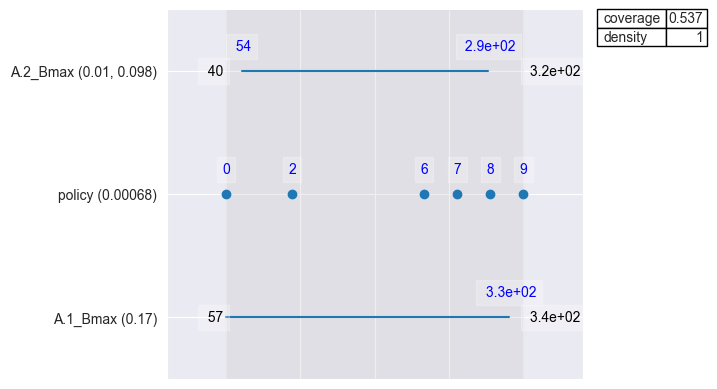

In [12]:
# box_expanndamage.inspect()
box_expanndamage.inspect(style='graph')
plt.show()

In [13]:
# x = cleaned_experiments.reset_index(drop=True)
# # Boolean array van experimenten in de box
# in_box_expanndamage = box_expanndamage.yi  # Deze is altijd even lang als x na reset_index
#
# # Selecteer de experimenten die in de box vallen
# experiments_in_box_expanndamage = x.loc[in_box_expanndamage]
#
# # Unieke policies selecteren
# robust_policies_expanndamage = experiments_in_box_expanndamage['policy'].unique()
#
# # Robuuste policies opzoeken in originele experimenten
# robust_policies_df_expanndamage = experiments[experiments['policy'].isin(robust_policies_expanndamage)].drop_duplicates(subset='policy')
#
# # Toon resultaat
# print("Robust Policies for Expected annual damage:")
# display(robust_policies_df_expanndamage)

In [14]:
# # Maak een samengestelde outcome "All Costs" aan door de drie relevante outcomes op te tellen
# # Zorg ervoor dat deze keys bestaan in je outcomes dictionary
# all_costs = (
#     outcomes["RfR Total Costs"] +
#     outcomes["Dike Investment Costs"] +
#     outcomes["Expected Annual Damage"]
# )
#
# # Voeg "All Costs" toe aan de outcomes dictionary voor verdere analyse
# outcomes["All Costs"] = all_costs


In [15]:
# from ema_workbench.analysis import prim
# import numpy as np
# import matplotlib.pyplot as plt
# import warnings
#
# # Vermijd Pandas dtype warning
# warnings.filterwarnings("ignore", category=FutureWarning)
#
# # Stel vulnerability condition in
# data_allcost = outcomes["All Costs"]
# y_allcost = (data_allcost < np.percentile(data_allcost, 10)).astype(int)
#
# # Voer PRIM uit
# prim_alg_allcost = prim.Prim(experiments, y_allcost, threshold=0.8)
# box_allcost = prim_alg_allcost.find_box()
# box_allcost.show_tradeoff()
# plt.show()

In [16]:
# box_allcost.inspect()
# box_allcost.inspect(style='graph')
# plt.show()

In [17]:
# x = cleaned_experiments.reset_index(drop=True)
# # Boolean array van experimenten in de box
# in_box_allcost = box_allcost.yi  # Deze is altijd even lang als x na reset_index
#
# # Selecteer de experimenten die in de box vallen
# experiments_in_box_allcost = x.loc[in_box_allcost]
#
# # Unieke policies selecteren
# robust_policies_allcost = experiments_in_box_allcost['policy'].unique()
#
# # Robuuste policies opzoeken in originele experimenten
# robust_policies_df_allcost = experiments[experiments['policy'].isin(robust_policies_allcost)].drop_duplicates(subset='policy')
#
# # Toon resultaat
# print("Robust Policies for Expected annual damage:")
# display(robust_policies_df_allcost)

In [18]:
# # Stap 1: Extract de unieke policy-namen per outcome
# set_rfr = set(robust_policies_df_rfrtotalcost['policy'])
# set_damage = set(robust_policies_df_expanndamage['policy'])
# set_allcost = set(robust_policies_df_allcost['policy'])
#
# # Stap 2: Vind de intersectie (policies die in alle drie voorkomen)
# robust_policies_all = set_rfr & set_damage & set_allcost
#
# # Stap 3: Filter originele experimenten op deze policies
# robust_policies_df_all = experiments[experiments['policy'].isin(robust_policies_all)].drop_duplicates(subset='policy')
#
# # Stap 4: Toon resultaat
# print("Robust Policies for ALL outcomes (intersection of all PRIM analyses):")
# display(robust_policies_df_all)


In [19]:
# print(len(y_rfrtotalcost), len(y_dike_inv), len(y_expanndamage), len(cleaned_experiments))
#
# rfr_mask = box_rfrtotalcost.apply(cleaned_experiments)
# dike_mask = box_dike_inv.apply(cleaned_experiments)
# ead_mask = box_expanndamage.apply(cleaned_experiments)
#
# # 2. Combine the masks to find policies in ALL three boxes
# combined_mask = rfr_mask & dike_mask & ead_mask
#
# # 3. Extract those policies from the experiments
# best_policies = cleaned_experiments[combined_mask]
#
# # 4. (Optional) Show or save them
# import pandas as pd
# print(best_policies.head())

DIT KAN DENK IK WEG. HIER MOET DAN EIGEN TEKST MET UITLEG>

This figure shows the trade-off between coverage, density, and the number of restricted dimensions (i.e., a proxy for interpretability). Each dot corresponds to one candidate box. As an analyst, it is up to you to choose which box you want to inspect in more detail. Here you have to balance the three objectives. There is no hard rule that is used here. Note, however, that a density of lower than 0.5 means that less than half of the cases within the box of interest are of interest. So ideally, you start with higher density boxes. Moreover, you want boxes for which the box limits are statistically significant according to the quasi p-values. This means that the last box for a given number of restricted dimensions is also a good candidate box to inspect (here, for example, the last box with 2 dimensions and the last box with 3 dimensions).

This figure shows in gray the complete interval for each parameter. A blue line is used in the case of RealParameters to show the interval of the box identified by PRIM. For CategoricalParameters, a dot is used instead. The blue numbers give the specific limit. The numbers behind the y-labels indicate the quasi p-values. In the top right-hand corner, you can see the coverage and density of the identified box. So, what do we see in this case. First, both delta and stdev are not significant and should be ignored in the interpretation. This leaves b, q, and some of the policies as the key determinants. So, our top 10% worst performance for reliability occurs if b and q are low and for 6 out of the 10 policies. This covers 56% of the cases of interest, with a precision (i.e. density) of 80%. Now, you would go back to the model and try to understand why you get low reliability if b and q are low.

## 2. Visualize the results using Dimensional Stacking
Take the classification of outcomes as used in step 3 of scenario discovery, and instead visualize the results using dimensional stacking. How do these results compare to the insights from scenario discovery?

In [20]:
from ema_workbench.analysis import dimensional_stacking

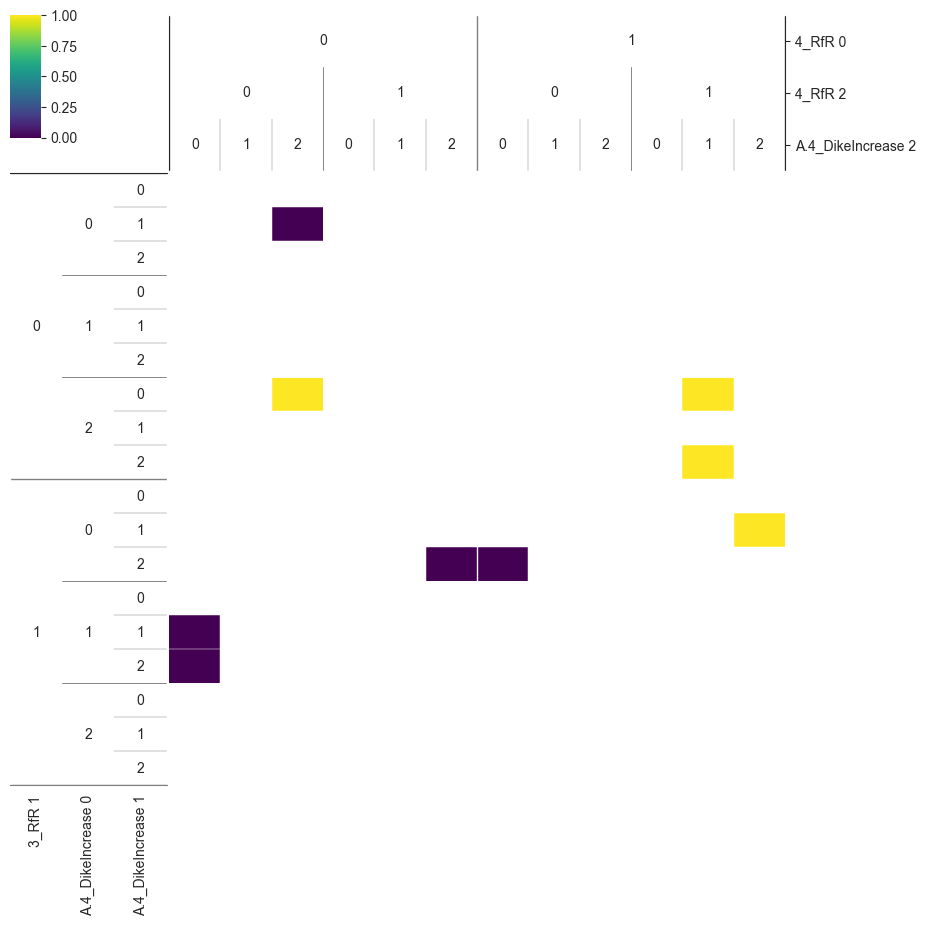

In [21]:
dimensional_stacking.create_pivot_plot(experiments, y_rfrtotalcost)
plt.show()

/Users/evalievanoijen/PycharmProjects/group25_mbdm/venv/lib/python3.13/site-packages/ema_workbench/analysis/dimensional_stacking.py:408: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pvt = pd.pivot_table(x_y_concat, values=ooi_label, index=rows, columns=columns, dropna=False)


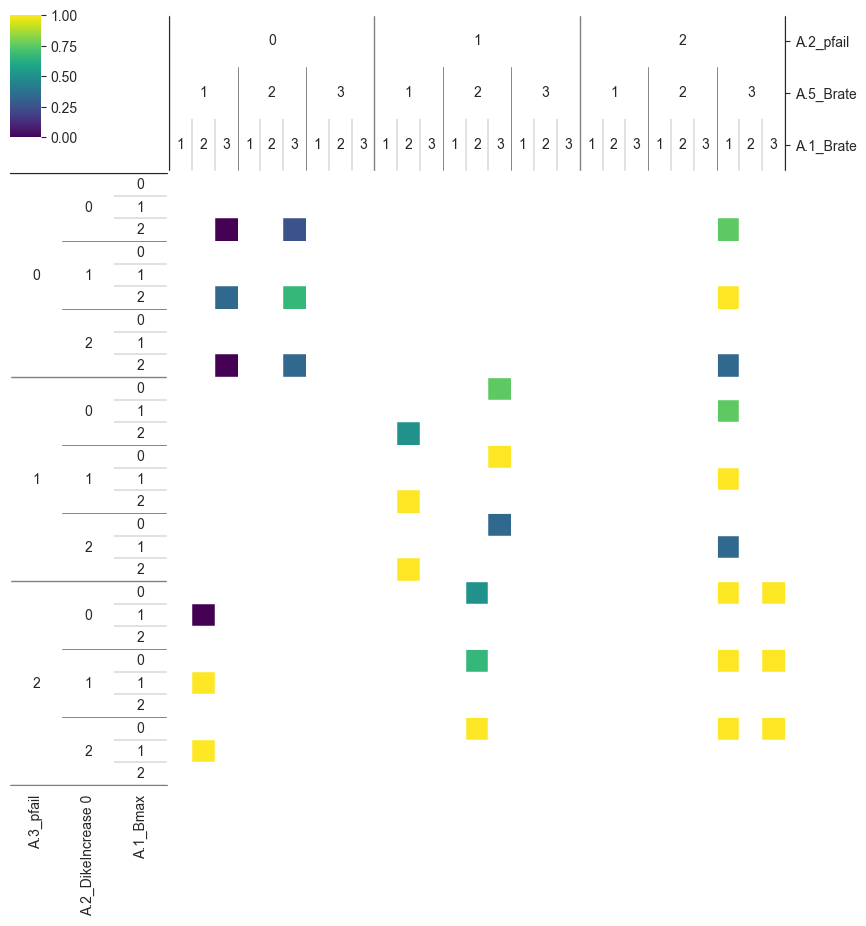

In [22]:
dimensional_stacking.create_pivot_plot(experiments,y_expanndamage)
plt.show()

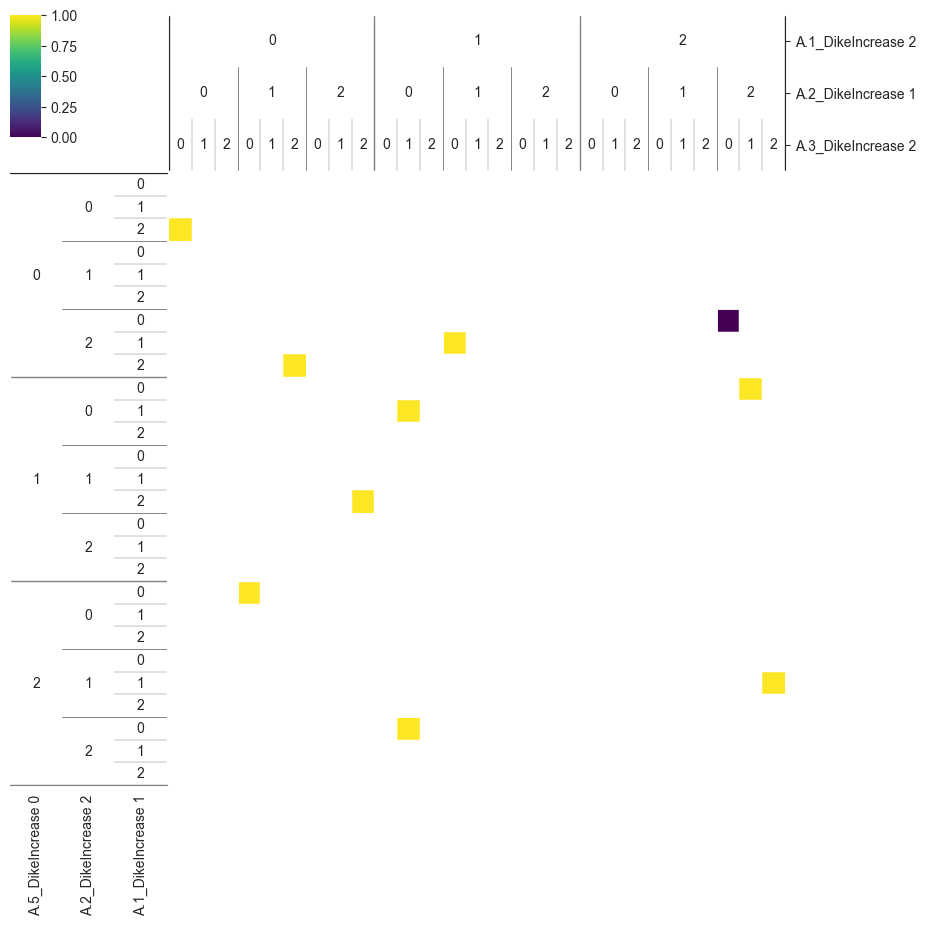

In [23]:
dimensional_stacking.create_pivot_plot(experiments,y_dike_inv)
plt.show()


DIT KAN WRS WEG. EIGEN TEKST HIER

As you can see, with the additional runs there are at least no white spaces left anymore. This is a good indication that we have a good coverage of the space.

#### Concluding remarks
In this notebook, we have applied several techniques for scenario discovery to the inter temporal version of the lake problem (i.e., the one with 100 decision variables). Both dimensional stacking and PRIM point to the importance of low values for the b and q parameters in driving low reliability. The last, qualitative, step is to go back to the model and offer a structural explanation (remember from system dynamics: structure explains behavior) for this behavior. So why do you get low reliability of b and q are low?